In [27]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from catboost import CatBoostClassifier ,Pool
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import joblib

EDA:

In [28]:
data = pd.read_csv("Mall_Customers.csv")

In [29]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [30]:
data.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [32]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [33]:
cols=data.columns
for col in cols:
    print(data[col].value_counts(),"\n")

CustomerID
185    1
186    1
187    1
188    1
189    1
      ..
4      1
5      1
6      1
7      1
8      1
Name: count, Length: 200, dtype: int64 

Gender
Female    112
Male       88
Name: count, dtype: int64 

Age
32    11
35     9
31     8
19     8
30     7
49     7
23     6
40     6
36     6
27     6
47     6
38     6
50     5
20     5
21     5
29     5
48     5
34     5
67     4
54     4
24     4
59     4
18     4
28     4
22     3
25     3
46     3
43     3
39     3
60     3
45     3
37     3
33     3
68     3
58     2
41     2
52     2
57     2
65     2
53     2
51     2
42     2
70     2
44     2
26     2
63     2
66     2
64     1
69     1
55     1
56     1
Name: count, dtype: int64 

Annual Income (k$)
54     12
78     12
60      6
48      6
63      6
       ..
101     2
113     2
120     2
126     2
137     2
Name: count, Length: 64, dtype: int64 

Spending Score (1-100)
42    8
55    7
73    6
46    6
52    5
     ..
89    1
85    1
23    1
8     1
18    1
Name: count, Le

Data Preprocessing

In [34]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [35]:
data['Gender']=data['Gender'].replace({'Male':1,'Female':0})

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


Data Visualization

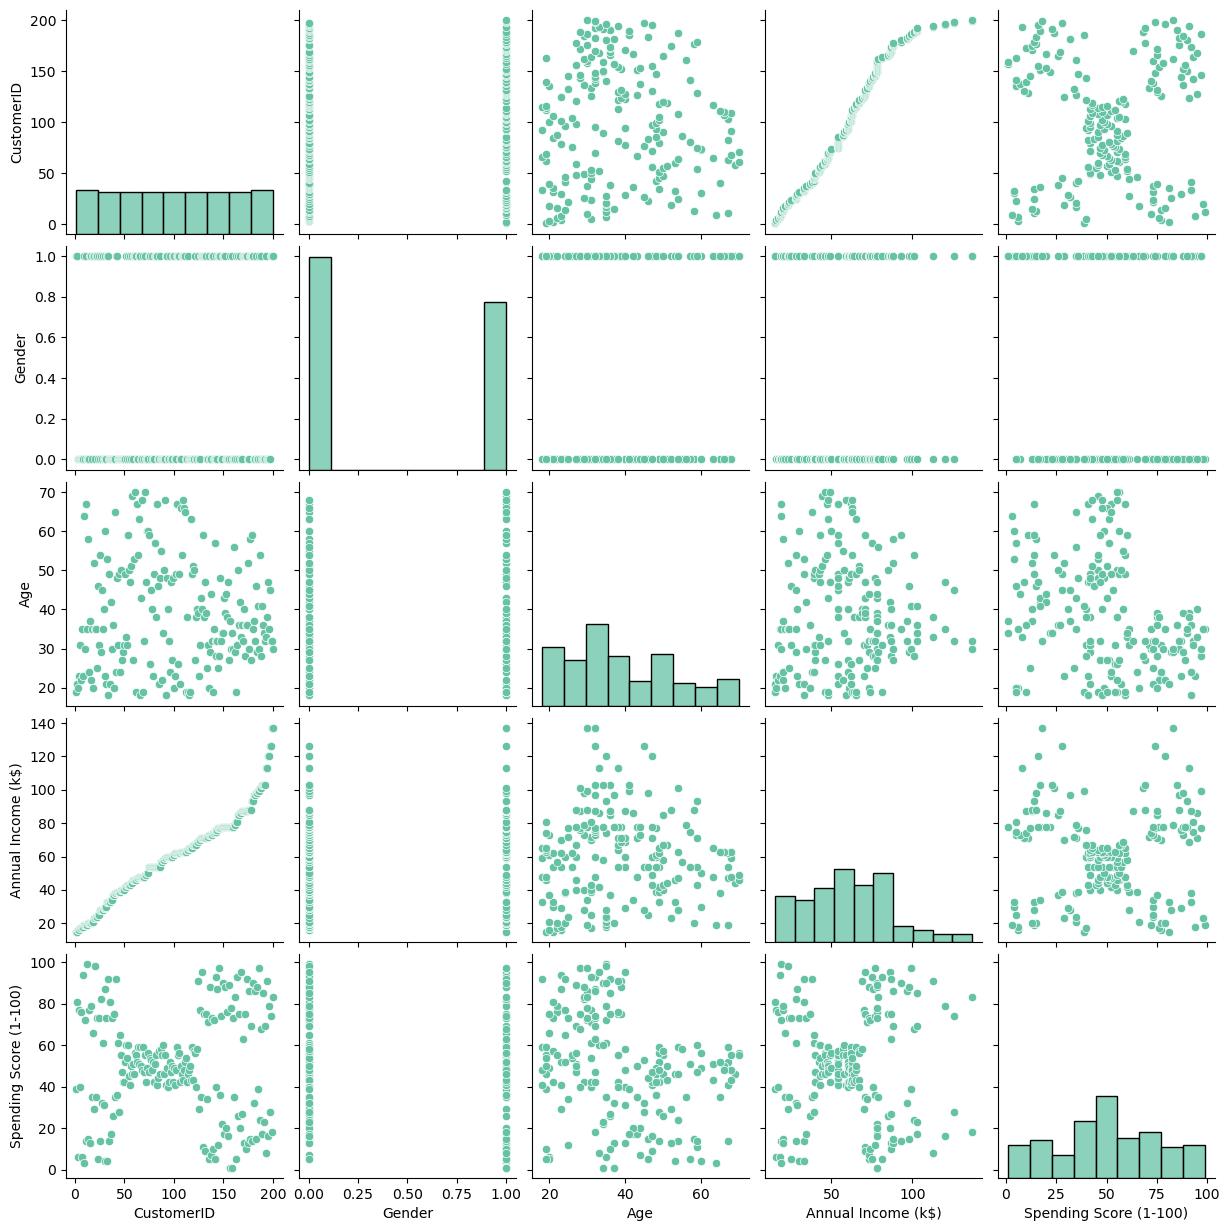

In [36]:
custom_palette = "Set2"
sns.set_palette(custom_palette)
sns.pairplot(data)

 Chossing the number of Clusters
 

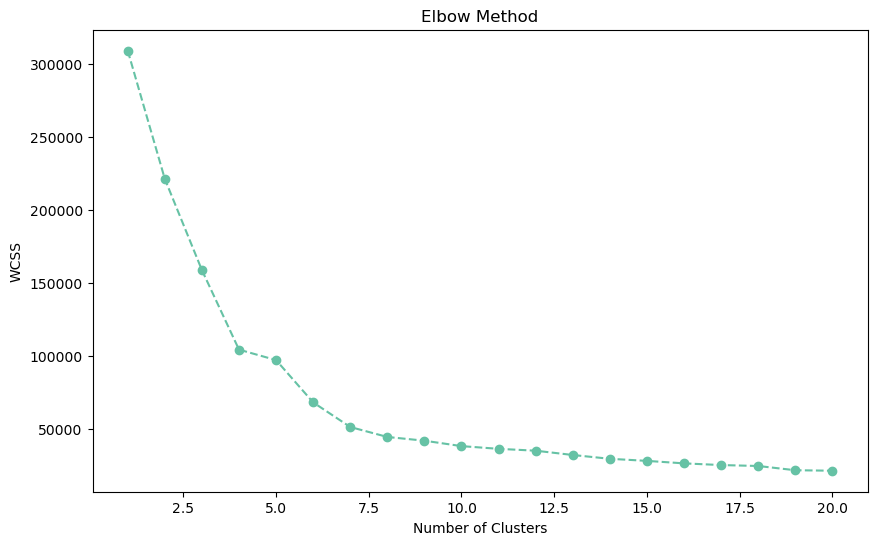

In [37]:
# wcss
from sklearn.cluster import KMeans
wcss = []
for i in range(1,21):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=42)
    kmeans.fit(data.iloc[:, 2:])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

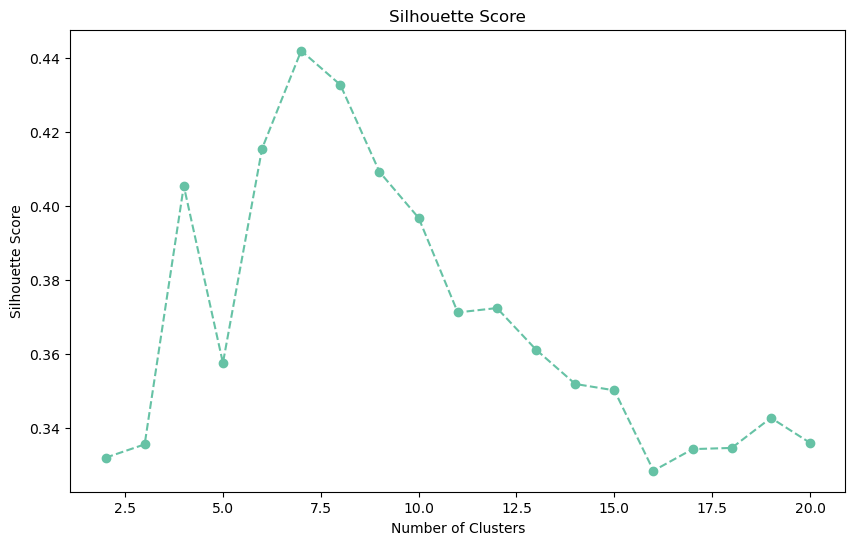

In [38]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data.iloc[:, 2:])
    score = silhouette_score(data.iloc[:, 2:], kmeans.labels_)
    silhouette_scores.append(score)

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Kmeans Clustering

In [39]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(data.iloc[:, 2:])

KMeans(n_clusters=5, random_state=42)

In [40]:
data['Cluster'] = kmeans.labels_

cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

         CustomerID    Gender        Age  Annual Income (k$)  \
Cluster                                                        
0         69.247191  0.382022  46.213483           47.719101   
1        190.000000  0.454545  32.454545          108.181818   
2         30.586207  0.482759  24.689655           29.586207   
3        162.000000  0.526316  40.394737           87.000000   
4        145.575758  0.454545  31.787879           76.090909   

         Spending Score (1-100)  
Cluster                          
0                     41.797753  
1                     82.727273  
2                     73.655172  
3                     18.631579  
4                     77.757576  


In [41]:

print("WCSS = ", kmeans.inertia_)

WCSS =  97211.84353980476


Validation of Clusters

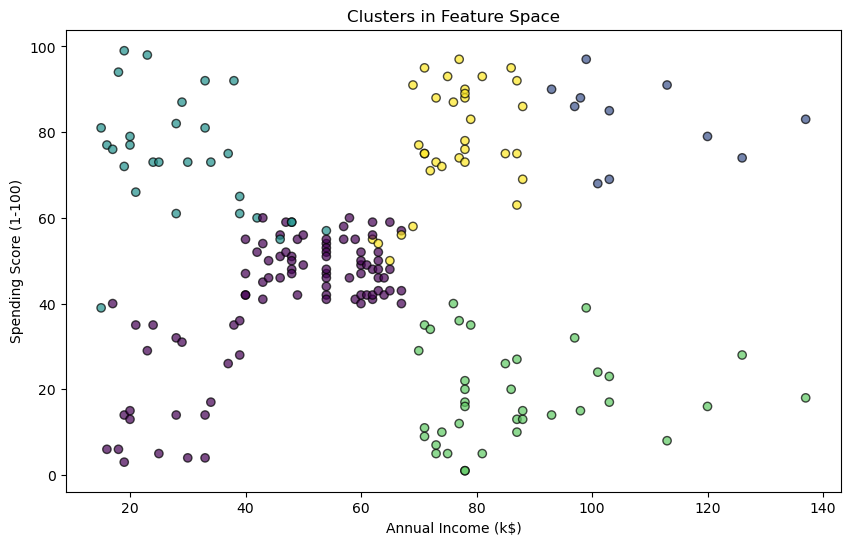

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c=data['Cluster'], cmap='viridis', edgecolors='k', alpha=0.7)
plt.title('Clusters in Feature Space')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


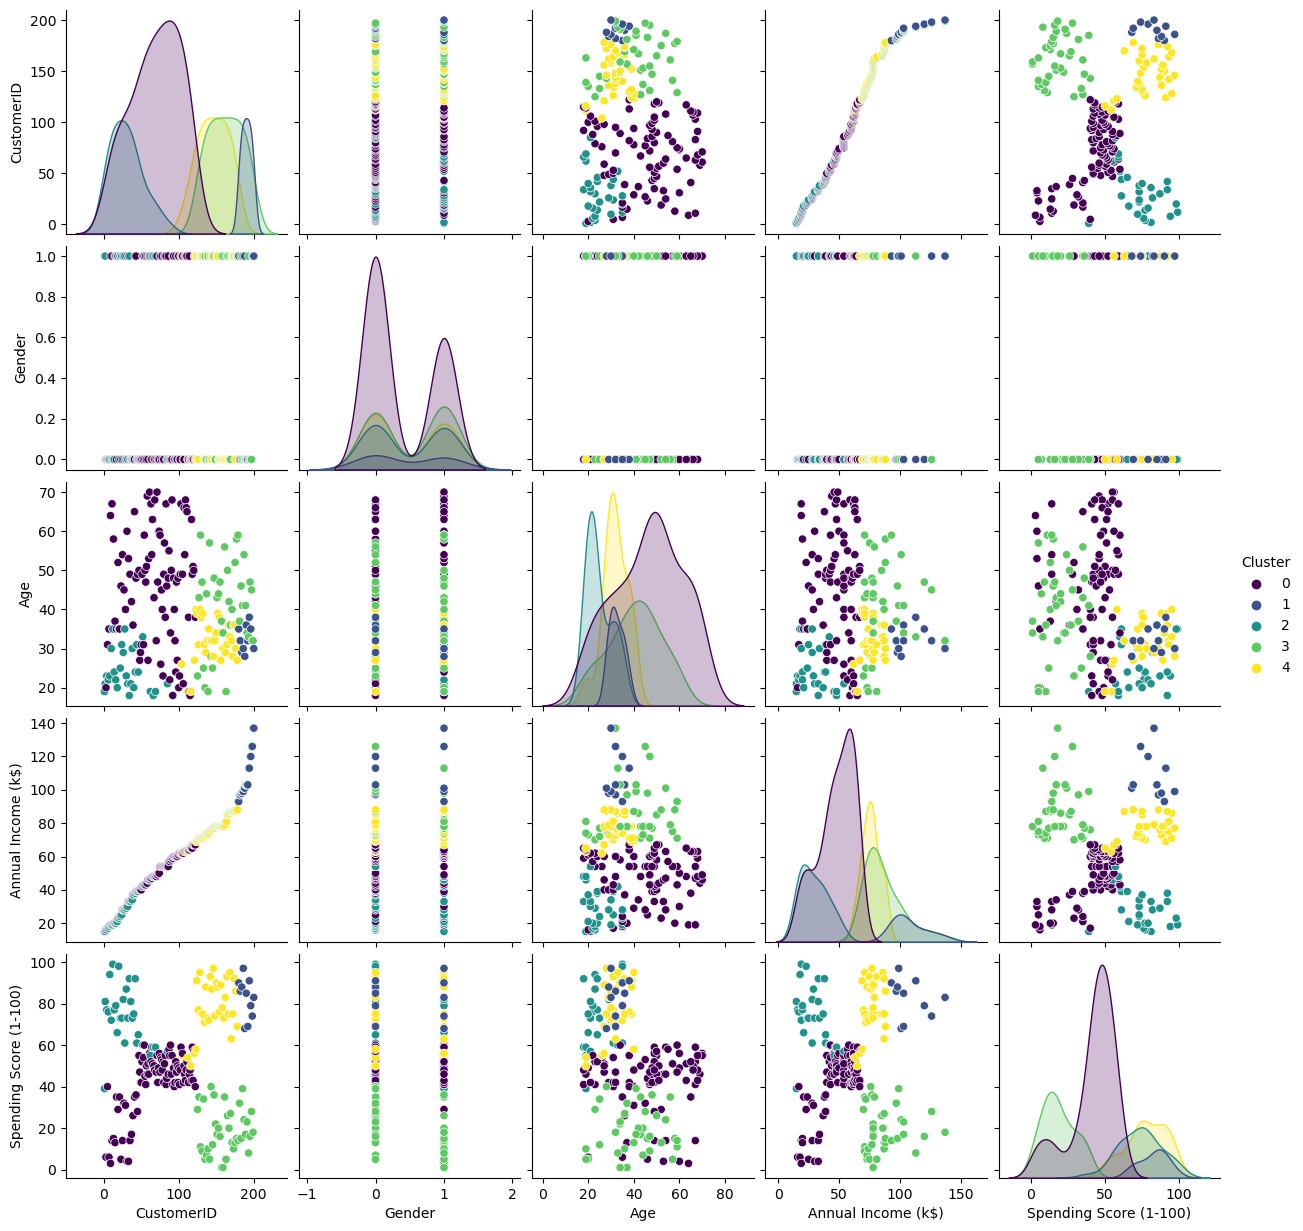

In [43]:
# Pairplot with clusters
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()

In [45]:
cluster_labels = {
    0: 'High Income, High Spending',
    1: 'Low Income, Low Spending',
    2: 'Mid Income, Mid Spending',
    3: 'High Income, Low Spending',
    4: 'Low Income, High Spending'
}
# Assign labels to clusters
data['Cluster Label'] = data['Cluster'].map(cluster_labels)

# Display customer profiles for each segment
print(data.groupby('Cluster Label').mean())

                            CustomerID    Gender        Age  \
Cluster Label                                                 
High Income, High Spending   69.247191  0.382022  46.213483   
High Income, Low Spending   162.000000  0.526316  40.394737   
Low Income, High Spending   145.575758  0.454545  31.787879   
Low Income, Low Spending    190.000000  0.454545  32.454545   
Mid Income, Mid Spending     30.586207  0.482759  24.689655   

                            Annual Income (k$)  Spending Score (1-100)  \
Cluster Label                                                            
High Income, High Spending           47.719101               41.797753   
High Income, Low Spending            87.000000               18.631579   
Low Income, High Spending            76.090909               77.757576   
Low Income, Low Spending            108.181818               82.727273   
Mid Income, Mid Spending             29.586207               73.655172   

                            Cluster  
C

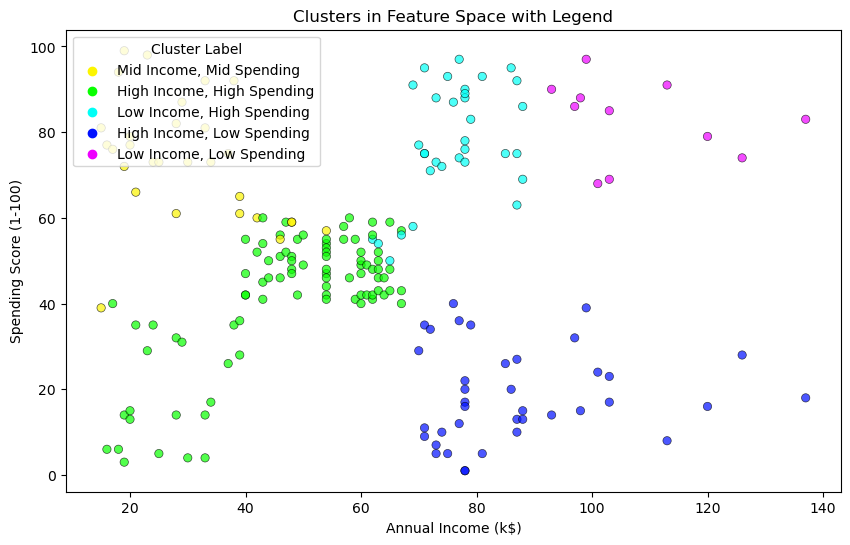

In [46]:
 #Define a custom color palette with distinctly different colors
custom_palette = sns.color_palette('hsv', n_colors=len(data['Cluster Label'].unique()))

# Plot clusters in 2D feature space with legend using the custom palette
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster Label', palette=custom_palette, edgecolor='k', alpha=0.7)
plt.title('Clusters in Feature Space with Legend')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster Label', loc='upper left')
plt.show()